In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

import seaborn as sns, matplotlib.pyplot as plt

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
# Fake News loaded
fake = pd.read_csv('Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# Fake news are labelled as 1
fake['label'] = 1
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [4]:
# True news loaded
true = pd.read_csv('True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
# True news labelled as 0
true['label'] = 0
true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [6]:
len(true), len(fake)

(21417, 23481)

In [7]:
# Both fake and true news are combined and first 2000 data points are only selected
df = pd.concat([fake.iloc[:1000,:],true.iloc[:1000,:]], axis=0)
df = df.sample(len(df))
df = df.reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,Ted Nugent Breaks Civility Pledge With Unhing...,After GOP Rep. Steve Scalise was shot during a...,News,"July 29, 2017",1
1,Factbox: Trump on Twitter (Nov 27) - Networks,The following statements were posted to the ve...,politicsNews,"November 27, 2017",0
2,Chaos Ensues After Man Accidentally Shoots Hi...,Maybe thoughts and prayers aren t the remedy...,News,"November 17, 2017",1
3,Mother Of DACA Recipient Who Died Rescuing Fl...,Donald Trump is set to end the Deferred Action...,News,"September 4, 2017",1
4,Republican Senator Corker says cannot support ...,WASHINGTON (Reuters) - U.S. Republican Senator...,politicsNews,"December 1, 2017",0


In [8]:
# Text & Title columns are combined and other columns except label are dropped
df.text = df.title + df.text
df = df[['text','label']]
df.head()

,text,label
0,Ted Nugent Breaks Civility Pledge With Unhing...,1
1,Factbox: Trump on Twitter (Nov 27) - NetworksT...,0
2,Chaos Ensues After Man Accidentally Shoots Hi...,1
3,Mother Of DACA Recipient Who Died Rescuing Fl...,1
4,Republican Senator Corker says cannot support ...,0


In [9]:
X = df.text
y = df.label

## Processing

In [10]:
# Data processing is done
corpus = []
ps = PorterStemmer()

for i in X:
    # Except alphabets, everything is removed
    new = re.sub('[^a-zA-Z]', ' ',i)
    # Converted to lower case
    new = new.lower()
    # Word tolenizing done
    new = nltk.word_tokenize(new)
    # English stop words are removed
    new = [ps.stem(i) for i in new if i not in stopwords.words('english')]
    new = ' '.join(new)
    corpus.append(new)

In [11]:
# Splitting into train and test data
X_train,X_test, y_train,y_test = train_test_split(corpus,y, train_size=0.7, random_state=100, stratify=y)

In [12]:
# 2 models are considered included in a pipeline to produce bag of words
mnb = Pipeline([('cnt_vec', CountVectorizer()),
               ('mnb', MultinomialNB())])

bnb = Pipeline([('cnt_vec', CountVectorizer()),
               ('bnb', BernoulliNB())])

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)

In [13]:
# Cross validation for first model
cv_mnb = cross_val_score(mnb,X_train,y_train,cv=folds)
cv_mnb.mean()

0.9671428571428571

In [14]:
# Cross validation for second model
cv_bnb = cross_val_score(bnb,X_train,y_train,cv=folds)
cv_bnb.mean()

0.987857142857143

In [15]:
# Hyperparameter tuning to find the best model and parameters
classifier = Pipeline([('classifier', mnb)])

hyp = [{'classifier':[mnb],
       'classifier__cnt_vec__ngram_range':[(1,1),(1,2),(2,1),(2,2)]},
      {'classifier':[bnb],
       'classifier__cnt_vec__ngram_range':[(1,1),(1,2),(2,1),(2,2)]}]

grid = GridSearchCV(estimator=classifier, param_grid=hyp, cv=folds, n_jobs=-1, scoring='accuracy',
                   verbose=3, return_train_score=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/tuhin/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.96714286 0.97857143        nan 0.98785714 0.98785714 0.99357143
        nan 0.99285714]
  warnings.warn(
/home/tuhin/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.99035714 1.                nan 1.         0.9975     1.
        nan 1.        ]
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=52, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        Pipeline(steps=[('cnt_vec',
                                                         CountVectorizer()),
                                                        ('mnb',
                                                         MultinomialNB())]))]),
             n_jobs=-1,
             param_grid=[{'classifier': [Pipeline(steps=[('cnt_vec',
                                                          CountVectorizer()),
                                                         ('mnb',
                                                          MultinomialNB())])],
                          'classifier__cnt_vec__ngram_range': [(1, 1), (1, 2),
                                                               (2, 1),
                                                               (2, 2)]},
                         {'classifier': [Pi

In [16]:
grid.best_estimator_, grid.best_score_

(Pipeline(steps=[('classifier',
                  Pipeline(steps=[('cnt_vec',
                                   CountVectorizer(ngram_range=(1, 2))),
                                  ('bnb', BernoulliNB())]))]),
 0.9935714285714287)

In [17]:
model = grid.best_estimator_

In [18]:
# Final training of model
model.fit(X_train,y_train)
y_test_pred = model.predict(X_test)
print('Accuracy of test data =',100*accuracy_score(y_test, y_test_pred),'%')

Accuracy of test data = 99.66666666666667 %


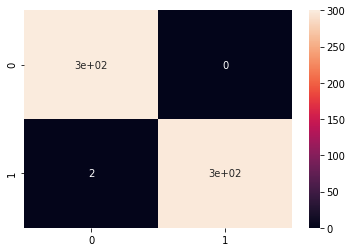

In [19]:
conf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf, annot=True)
plt.show()

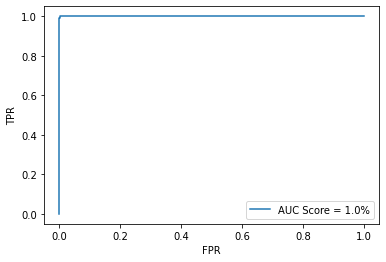

In [20]:
y_test_proba = [i[1] for i in model.predict_proba(X_test)]

auc = roc_auc_score(y_test,y_test_proba)
fpr,tpr,thresh = roc_curve(y_test,y_test_proba)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(('AUC Score = {}%'.format(round(auc,2)),),loc='lower right')
plt.show()

/home/tuhin/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


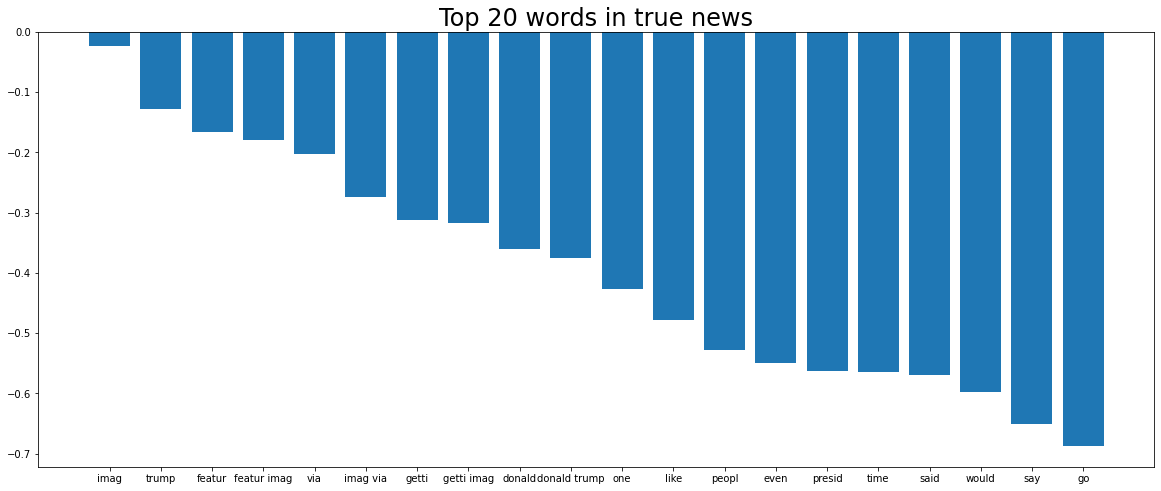

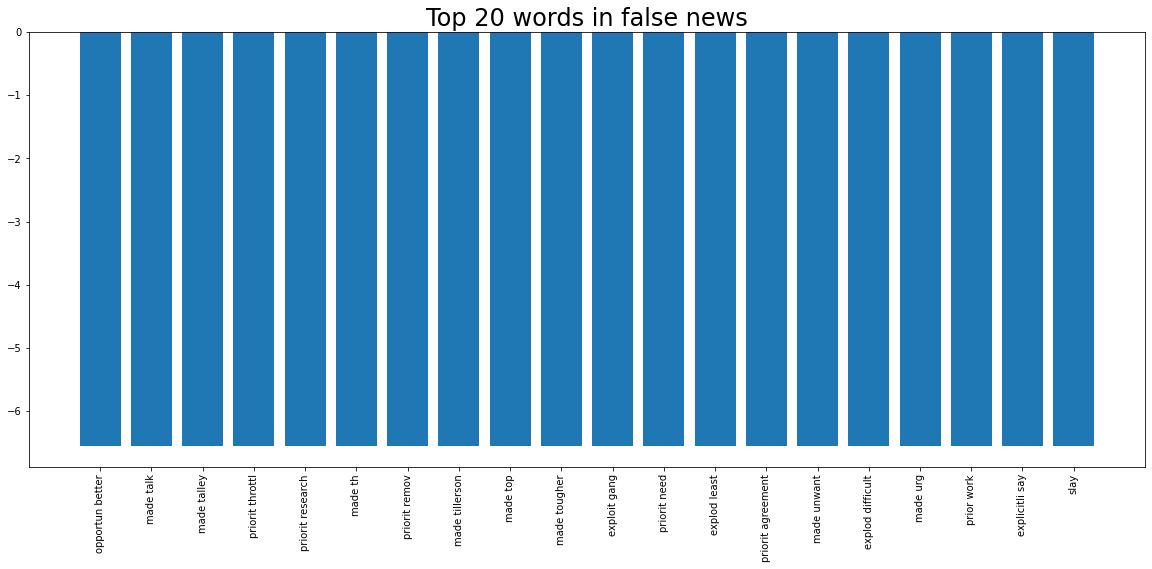

In [21]:
imp = pd.DataFrame({'features':model['classifier']['cnt_vec'].get_feature_names(), 'coef':model['classifier']['bnb'].coef_[0]})

top20 = imp.sort_values('coef',ascending=False).iloc[:20,:]
down20 = imp.sort_values('coef').iloc[:20,:]

plt.figure(figsize=(20,8))
plt.bar(top20.features,top20.coef)
plt.title('Top 20 words in true news', fontsize=24)
plt.show()

plt.figure(figsize=(20,8))
plt.bar(down20.features,down20.coef)
plt.title('Top 20 words in false news', fontsize=24)
plt.xticks(rotation=90)
plt.show()

In [23]:
import pickle
filename = 'fake_news_model'
outfile = open(filename,'wb')
pickle.dump(model,outfile)
outfile.close()